## Load final dataset

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pkl
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from pygam.terms import s,l,f
from pygam.pygam import LogisticGAM
from sklearn.metrics import (precision_score,f1_score,recall_score,accuracy_score,make_scorer)

from sklearn.inspection import permutation_importance

In [ ]:
df = pd.read_csv("datasets/dataset_final.csv") 
df.info()

## Final data modifications

Nothing applied yet


In [ ]:
#df["children"] = df["children"]+df["babies"]
#df["total_nights"] = df["stays_in_weekend_nights"]+df["stays_in_week_nights"]
#df = df.drop(["babies","stays_in_week_nights","stays_in_weekend_nights"],axis=1)

In [52]:
labels = df.iloc[:,0]
features = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(94980, 82) (23746, 82) (94980,) (23746,)


## Fit Optimized Models

RF, GB and SVM, and save them to pkl format.

In [ ]:
##########
# BUT FOCUS ON ONE MODEL IN THE BEGINNING
##########

In [ ]:
###############
# RANDOM FOREST
###############

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000,
                             min_samples_split=6,
                             max_features=0.1,
                             bootstrap=False)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

pd.DataFrame({"accuracy":[accuracy],"precision":[precision],"recall":[recall],"f1":[f1]})

In [ ]:
pkl.dump(rfc, open('models/rf.pkl', 'wb'))

In [ ]:
####################
# GRADIENT_BOOSTING
####################

In [ ]:
grad_boost = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)

grad_boost.fit(X_train,y_train)
y_pred = grad_boost.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

pd.DataFrame({"accuracy":[accuracy],"precision":[precision],"recall":[recall],"f1":[f1]})

In [ ]:
pkl.dump(grad_boost, open('models/gb.pkl', 'wb'))

In [ ]:
###############
# LINEAR SVM
###############

In [ ]:
svm = LinearSVC(C=0.003,max_iter=5000)

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

pd.DataFrame({"accuracy":[accuracy],"precision":[precision],"recall":[recall],"f1":[f1]})

In [ ]:
pkl.dump(svm, open('models/svm.pkl', 'wb'))

## Feature Importances

#### Load the trained models

In [4]:
rf = pkl.load(open('models/rf.pkl', 'rb'))
gb = pkl.load(open('models/gb.pkl', 'rb'))
svm = pkl.load(open('models/svm.pkl', 'rb'))

#### Features Importances (Random Forest makes every single scenario to explode)

Sklearn feature importance. Dataset containing all variables. Categorical vars dummy encoded with reference category (Model: GB)

In [14]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier

result = permutation_importance(gb, X_test, y_test, n_repeats=10, n_jobs=-1)
results = pd.DataFrame([],columns=['mean','std'])

cols = X_test.columns.tolist()
for i in result.importances_mean.argsort()[::-1]:
    print(f"{cols[i]}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")
    results.loc[cols[i]] = [result.importances_mean[i],result.importances_std[i]]

lead_time: 0.075 +/- 0.001
country_PRT: 0.057 +/- 0.001
total_of_special_requests: 0.046 +/- 0.001
adr: 0.044 +/- 0.002
market_segment_Online TA: 0.040 +/- 0.001
deposit_type_Non Refund: 0.032 +/- 0.001
arrival_date_week_number: 0.025 +/- 0.001
assigned_room_type_D: 0.021 +/- 0.001
previous_cancellations: 0.021 +/- 0.001
reserved_room_type_D: 0.017 +/- 0.001
required_car_parking_spaces: 0.014 +/- 0.001
customer_type_Transient: 0.013 +/- 0.001
hotel_Resort Hotel: 0.011 +/- 0.001
arrival_date_day_of_month: 0.008 +/- 0.001
booking_changes: 0.006 +/- 0.001
stays_in_week_nights: 0.006 +/- 0.001
previous_bookings_not_canceled: 0.004 +/- 0.000
meal_SC: 0.003 +/- 0.000
customer_type_Transient-Party: 0.003 +/- 0.000
assigned_room_type_E: 0.003 +/- 0.000
stays_in_weekend_nights: 0.002 +/- 0.001
market_segment_Direct: 0.002 +/- 0.000
reserved_room_type_E: 0.002 +/- 0.000
assigned_room_type_F: 0.002 +/- 0.000
assigned_room_type_G: 0.002 +/- 0.000
adults: 0.002 +/- 0.000
assigned_room_type_B: 0.002

In [15]:
results.to_csv('feature_importances/sklearn_feature_importances.csv')

Manual Permutation Feature Importance (Model: GB)

In [61]:
#Function which takes the model, the dataset, the list of columns to permute and the number or permutation.
#Creates the random permutations and runs the algorithm over the new dataset with the new columns.
#Computes the mean acc and std and returns them. This is done for every single attribute.

def perm_importance(model,X,y_truth,perm_cols,n,score=accuracy_score):
    X_data = X.copy()
    
    y_pred = model.predict(X_data)
    s0 = score(y_truth,y_pred)
    
    s_list = []
    for i in range(0,n):
        X_feats = X_data[perm_cols]
        
        index = X_feats.index
        index_permuted = np.random.permutation(index.values)
        X_feats = X_feats.loc[index_permuted,:] 
        X_data.loc[:,perm_cols] = X_feats.values.tolist() # don't drop variables, but substitute the values
                                                          # and take .values.tolist(), so index is ignored
        y_pred = model.predict(X_data)
        s = score(y_truth,y_pred)
        
        s_list.append(s0-s)
        
    importance_mean = np.mean(s_list,axis=0)
    importance_std = np.std(s_list,axis=0)
    
    # alternatively let you give back the whole list
    return importance_mean,importance_std;

In [6]:
#CATEG VARS: hotel, meal, country, market_segment, reserved_room_type, 
#assigned_room_type, deposit_type, customer_type

n = 10
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

acc_results = {}

z = 0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
        z += 1
        
        if z == len(cat_cols):
            break
          
        result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[cat_cols[z]] = [result_mean,result_std]

    else:
        perm_cols.append(c)
       
        result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[c] = [result_mean,result_std]
        
feat_importances = pd.DataFrame.from_dict(acc_results)
feat_importances = feat_importances.transpose() 
feat_importances = feat_importances.rename(columns={0:'mean',1:'std'})
feat_importances = feat_importances.sort_values(by=['mean'],ascending=False)
feat_importances

,mean,std
market_segment,0.080814,0.001316
lead_time,0.073667,0.001930
total_of_special_requests,0.047389,0.001070
reserved_room_type,0.044892,0.001336
adr,0.044639,0.001255
customer_type,0.031673,0.000962
deposit_type,0.030401,0.001401
arrival_date_week_number,0.025048,0.000767
assigned_room_type,0.020968,0.000527
previous_cancellations,0.019751,0.000391


PIMP Manual Permutation Feature Importance (Model: GB)

In [57]:
def pimp(X_train,X_test,y_train,y_test,n):
    importances = pd.DataFrame()
    
    for i in range(0,n):
        index = y_train.index
        index_permuted = np.random.permutation(index.values)
        y_train = y_train.loc[index_permuted,] 

        gb = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)
        gb.fit(X_train,y_train)
        
        m = 10
        cols = X_test.columns.tolist()
        cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
                    'assigned_room_type','deposit_type','customer_type']

        acc_results = {}

        z = 0
        for c in cols:
            perm_cols = []
            if c.startswith(tuple(cat_cols)):
                perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
                z += 1

                if z == len(cat_cols):
                    break

                result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,m)
                acc_results[cat_cols[z]] = result_mean

            else:
                perm_cols.append(c)

                result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,m)
                acc_results[c] = result_mean

        feat_importances = pd.DataFrame.from_dict(acc_results,orient='index',columns=[i])
        #feat_importances = feat_importances.transpose() 
        #feat_importances = feat_importances.rename(columns={0:'mean'})
        #feat_importances = feat_importances.sort_values(by=[n],ascending=False)
        importances = pd.concat([importances, feat_importances],axis=1)
        print(importances)
    
    return importances

In [25]:
n = 15

importances = pimp(X_train,X_test,y_train,y_test,n)
importances = importances.loc[feat_importances.index,:]
importances

Hello
                                       0
lead_time                      -0.005597
arrival_date_week_number       -0.012309
arrival_date_day_of_month      -0.010355
stays_in_weekend_nights        -0.002464
stays_in_week_nights           -0.006894
adults                         -0.006426
children                       -0.000762
babies                         -0.000067
previous_cancellations          0.000350
previous_bookings_not_canceled -0.000665
booking_changes                -0.002101
days_in_waiting_list           -0.001129
adr                            -0.017637
required_car_parking_spaces    -0.000783
total_of_special_requests      -0.002097
meal                           -0.000282
country                        -0.002796
market_segment                 -0.011897
reserved_room_type             -0.003967
assigned_room_type             -0.000539
deposit_type                   -0.001941
customer_type                   0.000055
Hello
                                       0     

                                       0         1         2         3  \
lead_time                      -0.005597 -0.005854 -0.014171 -0.006692   
arrival_date_week_number       -0.012309 -0.003179 -0.008111 -0.011484   
arrival_date_day_of_month      -0.010355 -0.005230 -0.005344 -0.011295   
stays_in_weekend_nights        -0.002464 -0.001524 -0.001748 -0.003836   
stays_in_week_nights           -0.006894 -0.001444 -0.006738 -0.005003   
adults                         -0.006426 -0.002986 -0.001794 -0.003297   
children                       -0.000762 -0.001537 -0.000754 -0.001390   
babies                         -0.000067 -0.000126  0.000248 -0.000232   
previous_cancellations          0.000350  0.002708  0.001832 -0.000577   
previous_bookings_not_canceled -0.000665  0.000695 -0.001200 -0.002590   
booking_changes                -0.002101 -0.004194 -0.005550 -0.002337   
days_in_waiting_list           -0.001129 -0.000194 -0.000762  0.000518   
adr                            -0.0176

                                       0         1         2         3  \
lead_time                      -0.005597 -0.005854 -0.014171 -0.006692   
arrival_date_week_number       -0.012309 -0.003179 -0.008111 -0.011484   
arrival_date_day_of_month      -0.010355 -0.005230 -0.005344 -0.011295   
stays_in_weekend_nights        -0.002464 -0.001524 -0.001748 -0.003836   
stays_in_week_nights           -0.006894 -0.001444 -0.006738 -0.005003   
adults                         -0.006426 -0.002986 -0.001794 -0.003297   
children                       -0.000762 -0.001537 -0.000754 -0.001390   
babies                         -0.000067 -0.000126  0.000248 -0.000232   
previous_cancellations          0.000350  0.002708  0.001832 -0.000577   
previous_bookings_not_canceled -0.000665  0.000695 -0.001200 -0.002590   
booking_changes                -0.002101 -0.004194 -0.005550 -0.002337   
days_in_waiting_list           -0.001129 -0.000194 -0.000762  0.000518   
adr                            -0.0176

                                      0         1         2         3   \
lead_time                      -0.005597 -0.005854 -0.014171 -0.006692   
arrival_date_week_number       -0.012309 -0.003179 -0.008111 -0.011484   
arrival_date_day_of_month      -0.010355 -0.005230 -0.005344 -0.011295   
stays_in_weekend_nights        -0.002464 -0.001524 -0.001748 -0.003836   
stays_in_week_nights           -0.006894 -0.001444 -0.006738 -0.005003   
adults                         -0.006426 -0.002986 -0.001794 -0.003297   
children                       -0.000762 -0.001537 -0.000754 -0.001390   
babies                         -0.000067 -0.000126  0.000248 -0.000232   
previous_cancellations          0.000350  0.002708  0.001832 -0.000577   
previous_bookings_not_canceled -0.000665  0.000695 -0.001200 -0.002590   
booking_changes                -0.002101 -0.004194 -0.005550 -0.002337   
days_in_waiting_list           -0.001129 -0.000194 -0.000762  0.000518   
adr                            -0.0176

                                      0         1         2         3   \
lead_time                      -0.005597 -0.005854 -0.014171 -0.006692   
arrival_date_week_number       -0.012309 -0.003179 -0.008111 -0.011484   
arrival_date_day_of_month      -0.010355 -0.005230 -0.005344 -0.011295   
stays_in_weekend_nights        -0.002464 -0.001524 -0.001748 -0.003836   
stays_in_week_nights           -0.006894 -0.001444 -0.006738 -0.005003   
adults                         -0.006426 -0.002986 -0.001794 -0.003297   
children                       -0.000762 -0.001537 -0.000754 -0.001390   
babies                         -0.000067 -0.000126  0.000248 -0.000232   
previous_cancellations          0.000350  0.002708  0.001832 -0.000577   
previous_bookings_not_canceled -0.000665  0.000695 -0.001200 -0.002590   
booking_changes                -0.002101 -0.004194 -0.005550 -0.002337   
days_in_waiting_list           -0.001129 -0.000194 -0.000762  0.000518   
adr                            -0.0176

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
market_segment,-0.011897,-0.012718,-0.010440,-0.024320,-0.015632,-0.005542,-0.009143,-0.008275,-0.013472,-0.007593,-0.010280,-0.012074,-0.008376,-0.009741,-0.020403
lead_time,-0.005597,-0.005854,-0.014171,-0.006692,-0.012069,-0.001314,-0.009143,0.000248,-0.004519,0.003508,-0.011505,-0.014204,-0.008970,-0.009303,-0.012844
total_of_special_requests,-0.002097,-0.011113,0.000114,-0.006843,-0.011686,-0.000606,-0.008679,-0.012558,-0.002645,-0.005104,-0.002064,-0.014167,-0.008818,0.001891,-0.002122
reserved_room_type,-0.003967,0.004346,-0.007854,-0.003154,-0.002409,0.006119,-0.013510,-0.003613,-0.000253,0.002527,0.007012,0.003154,-0.010318,-0.004847,-0.000265
adr,-0.017637,-0.006620,-0.011678,-0.013674,-0.004809,0.000131,-0.000476,-0.003099,-0.007761,-0.003091,-0.008827,-0.013741,-0.011067,-0.004068,-0.014057
customer_type,0.000055,0.004590,-0.007656,0.001204,-0.001777,-0.000724,0.005226,0.004940,0.002678,0.002573,0.005272,0.003386,0.008730,0.002691,0.001962
deposit_type,-0.001941,-0.005824,-0.003121,-0.009016,-0.004493,-0.006970,-0.007155,-0.006864,-0.007597,-0.004081,-0.001659,-0.004578,-0.003786,-0.006628,-0.006616
arrival_date_week_number,-0.012309,-0.003179,-0.008111,-0.011484,-0.010722,-0.004026,-0.003925,-0.004127,-0.005428,-0.007942,-0.005702,-0.011193,-0.003099,-0.007496,-0.009176
assigned_room_type,-0.000539,-0.000446,-0.003184,-0.004009,-0.001807,-0.002775,0.000632,-0.004447,-0.007719,-0.004354,-0.001533,-0.002459,-0.003137,-0.003601,-0.004333
previous_cancellations,0.000350,0.002708,0.001832,-0.000577,0.002796,0.003483,0.000531,-0.001154,0.002148,0.001512,0.002695,0.002939,0.000619,0.000307,0.001613


In [30]:
feat_importances.to_csv('feature_importances/manual_feature_importances.csv')
importances.to_csv('feature_importances/manual_pimp_importances.csv')

START HERE AFTER LOADING DATA

In [37]:
# from statsmodels.distributions.empirical_distribution import ECDF

# for (row,feat_imp) in zip(importances.iterrows(),feat_importances.iterrows()):
#     ecdf = ECDF(np.array(row[1]))
#     imp = ecdf(feat_imp[1][0])
#     if imp < 0.05:
#         print("Feature " + row[0] + " is important. Value: " + str(imp))
#     else:
#         print("Feature " + row[0] + " is not important. p-value: " + str(imp))

sklearn_importances = pd.read_csv('feature_importances/sklearn_feature_importances.csv',index_col=0)
feat_importances = pd.read_csv('feature_importances/manual_feature_importances.csv',index_col=0)
importances = pd.read_csv('feature_importances/pimp_importances.csv',index_col=0)

for (row,feat_imp) in zip(importances.iterrows(),feat_importances.iterrows()):
    p = np.mean(abs(np.array(row[1]))>abs(feat_imp[1][0]))
    if p < 0.05:
        print("Feature " + row[0] + " is important. p-value: ", p)
    else:
        print("Feature " + row[0] + " is not important. p-value: ", p)
                
#mean/std
#cdfnorm(mean,std,perm imp feat) [p-value]

#Write out the most important ones based on p-values
#Try random forest
#Go to feature selection and look at feature importances from random forest

Feature market_segment is important. p-value:  0.0
Feature lead_time is important. p-value:  0.0
Feature total_of_special_requests is important. p-value:  0.0
Feature reserved_room_type is important. p-value:  0.0
Feature adr is important. p-value:  0.0
Feature customer_type is important. p-value:  0.0
Feature deposit_type is important. p-value:  0.0
Feature arrival_date_week_number is important. p-value:  0.0
Feature assigned_room_type is important. p-value:  0.0
Feature previous_cancellations is important. p-value:  0.0
Feature required_car_parking_spaces is important. p-value:  0.0
Feature meal is important. p-value:  0.0
Feature arrival_date_day_of_month is not important. p-value:  0.2
Feature booking_changes is important. p-value:  0.0
Feature country is important. p-value:  0.0
Feature stays_in_week_nights is not important. p-value:  0.2
Feature previous_bookings_not_canceled is important. p-value:  0.0
Feature stays_in_weekend_nights is not important. p-value:  0.4
Feature adult

Histogram of our algorithm

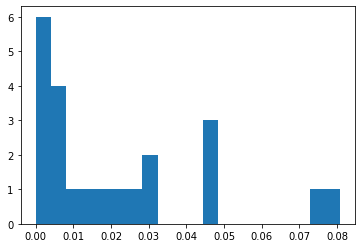

In [33]:
plt.hist(np.array(feat_importances['mean']), bins=20, label="Sklearn Feature Importances")
plt.show()

In [8]:
np.median(feat_importances['mean'])

0.01229470226564477

Sklearn most driving categories in categorical variables, considering classical dummy encoding

In [42]:
df = pd.read_csv("datasets/dataset_norefcats.csv") 
df = df.drop(['hotel_City Hotel'],axis=1)

labels = df.iloc[:,0]
features = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

gb = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)

gb.fit(X_train,y_train)

pkl.dump(gb, open('models/gb_norefcats.pkl', 'wb'))

result = permutation_importance(gb, X_test, y_test, n_repeats=10, n_jobs=-1)
results = pd.DataFrame([],columns=['mean','std'])

cols = X_test.columns.tolist()
for i in result.importances_mean.argsort()[::-1]:
    print(f"{cols[i]}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")
    results.loc[cols[i]] = [result.importances_mean[i],result.importances_std[i]]

lead_time: 0.076 +/- 0.002
country_PRT: 0.058 +/- 0.002
total_of_special_requests: 0.046 +/- 0.001
adr: 0.046 +/- 0.002
market_segment_Online TA: 0.040 +/- 0.001
assigned_room_type_A: 0.028 +/- 0.001
arrival_date_week_number: 0.028 +/- 0.001
deposit_type_Non Refund: 0.025 +/- 0.001
reserved_room_type_A: 0.025 +/- 0.001
previous_cancellations: 0.020 +/- 0.001
required_car_parking_spaces: 0.015 +/- 0.001
customer_type_Transient: 0.013 +/- 0.000
hotel_Resort Hotel: 0.010 +/- 0.001
arrival_date_day_of_month: 0.009 +/- 0.001
booking_changes: 0.006 +/- 0.001
stays_in_week_nights: 0.005 +/- 0.001
meal_SC: 0.004 +/- 0.000
previous_bookings_not_canceled: 0.003 +/- 0.000
assigned_room_type_D: 0.003 +/- 0.000
customer_type_Transient-Party: 0.003 +/- 0.000
stays_in_weekend_nights: 0.002 +/- 0.000
country_ITA: 0.002 +/- 0.000
adults: 0.002 +/- 0.000
country_ESP: 0.001 +/- 0.000
reserved_room_type_D: 0.001 +/- 0.001
meal_HB: 0.001 +/- 0.000
assigned_room_type_F: 0.001 +/- 0.000
country_FRA: 0.001 +/

In [43]:
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

results_updated = pd.DataFrame([],columns=['mean','std'])

z=0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
        new_df = results.loc[perm_cols,:]
        m = new_df['mean'].mean() #mean of all of them
        sd = new_df['std'].mean()
        results_updated.loc[cat_cols[z]] = [m,sd]
        z += 1
        
        if z == len(cat_cols):
            break
    else:
        new_df = results.loc[c,:]
        r = new_df
        results_updated.loc[c] = [r['mean'],r['std']]

results_updated = results_updated.sort_values(by=['mean'],ascending=False)
results_updated

,mean,std
lead_time,0.075609,0.001709
total_of_special_requests,0.046404,0.001247
adr,0.045721,0.001520
arrival_date_week_number,0.027634,0.000920
previous_cancellations,0.019734,0.000585
required_car_parking_spaces,0.014676,0.001063
hotel,0.009863,0.000511
arrival_date_day_of_month,0.008949,0.001153
deposit_type,0.008674,0.000476
booking_changes,0.006106,0.000588


In [44]:
results_updated.to_csv('feature_importances/sklearn_feature_importances_mean_categ.csv')

Dataset containing all variables. Categorical vars dummy encoded with no reference category (CLASSICAL DUMMY)

In [ ]:
df = pd.read_csv("datasets/dataset_norefcats.csv") 

labels = df.iloc[:,0]
features = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

gb = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)

gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

pd.DataFrame({"accuracy":[accuracy],"precision":[precision],"recall":[recall],"f1":[f1]})

In [ ]:
result = permutation_importance(gb, X_test, y_test, n_repeats=10, n_jobs=-1)

cols = X_test.columns.tolist()
for i in result.importances_mean.argsort()[::-1]:
    print(f"{cols[i]}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")

In [ ]:
n = 10
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

acc_results = {}

z = 0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
        z += 1
        
        if z == len(cat_cols):
            break
        
              
        result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[cat_cols[z]] = [result_mean,result_std]

    else:
        perm_cols.append(c)
       
        result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[c] = [result_mean,result_std]
        
feat_importances = pd.DataFrame.from_dict(acc_results)
feat_importances = feat_importances.transpose() 
feat_importances = feat_importances.rename(columns={0:'mean',1:'std'})
feat_importances = feat_importances.sort_values(by=['mean'],ascending=False)
feat_importances

Feature selection, retraining and feature importances based on dataset with ref cats (Model: GB)

In [58]:
df = pd.read_csv("datasets/dataset_final.csv") 

#Fuse nights
col_nights = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df.insert(1, 'total_nights', col_nights)
df = df.drop(['stays_in_week_nights','stays_in_weekend_nights'],axis=1)
#Fuse guests
col_guests = df['adults'] + df['children'] + df['babies']
df.insert(1, 'total_guests', col_guests)
df = df.drop(['adults','children','babies'],axis=1)
#Drop almost 0-importance features (<0.01): arrival_date_day_of_month, booking_changes, country,
#previous_bookings_not_cancelled, days_in_waiting_list.
df = df.drop(['arrival_date_day_of_month','booking_changes','previous_bookings_not_canceled',
             'days_in_waiting_list'],axis=1)
df = df.loc[:,~df.columns.str.startswith('country')]

labels = df.iloc[:,0]
features = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)

gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

df_meas = pd.DataFrame({"accuracy":[accuracy],"precision":[precision],"recall":[recall],"f1":[f1]})
df_meas.to_csv('results/final_feat_imps_gb.csv',index=False)
print(df_meas)
pkl.dump(gb, open('models/gb_final.pkl', 'wb'))

In [48]:
n = 10
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

acc_results = {}

z = 0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
        z += 1
        
        if z == len(cat_cols):
            break
          
        result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[cat_cols[z]] = [result_mean,result_std]

    else:
        perm_cols.append(c)
       
        result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[c] = [result_mean,result_std]
        
final_feat_importances = pd.DataFrame.from_dict(acc_results)
final_feat_importances = final_feat_importances.transpose() 
final_feat_importances = final_feat_importances.rename(columns={0:'mean',1:'std'})
final_feat_importances = final_feat_importances.sort_values(by=['mean'],ascending=False)

final_feat_importances.to_csv('feature_importances/final_manual_feature_importances.csv')

   accuracy  precision    recall        f1
0  0.862714   0.840569  0.782443  0.810465


In [49]:
final_feat_importances

,mean,std
customer_type,0.104721,0.001192
lead_time,0.078236,0.001635
adr,0.055769,0.001434
total_of_special_requests,0.053710,0.001373
reserved_room_type,0.042007,0.001411
arrival_date_week_number,0.036503,0.001407
previous_cancellations,0.030864,0.000711
deposit_type,0.030675,0.001417
assigned_room_type,0.019582,0.001279
total_nights,0.014861,0.000856


In [62]:
n = 15

final_feat_importances = pd.read_csv('feature_importances/final_manual_feature_importances.csv', index_col = 0)

importances = pimp(X_train,X_test,y_train,y_test,n)
importances = importances.loc[final_feat_importances.index,:]
importances

                                    0
total_guests                -0.008524
total_nights                -0.009564
lead_time                   -0.010945
arrival_date_week_number    -0.011661
previous_cancellations       0.001006
adr                         -0.017064
required_car_parking_spaces -0.002434
total_of_special_requests   -0.004632
meal                        -0.000783
country                     -0.002817
market_segment               0.000000
reserved_room_type          -0.007163
assigned_room_type          -0.004860
deposit_type                -0.011067
customer_type                0.003622
                                    0         1
total_guests                -0.008524 -0.007416
total_nights                -0.009564 -0.010115
lead_time                   -0.010945 -0.017523
arrival_date_week_number    -0.011661 -0.021204
previous_cancellations       0.001006 -0.000998
adr                         -0.017064 -0.020429
required_car_parking_spaces -0.002434 -0.003116
total_of

                                    0         1         2         3         4  \
total_guests                -0.008524 -0.007416 -0.006784 -0.003537 -0.007450   
total_nights                -0.009564 -0.010115 -0.005327 -0.005167 -0.001213   
lead_time                   -0.010945 -0.017523 -0.009471 -0.007517  0.002514   
arrival_date_week_number    -0.011661 -0.021204 -0.014175 -0.006443 -0.006169   
previous_cancellations       0.001006 -0.000998  0.003478  0.002725  0.001407   
adr                         -0.017064 -0.020429 -0.008380 -0.007269 -0.011914   
required_car_parking_spaces -0.002434 -0.003116 -0.002560 -0.002649 -0.000939   
total_of_special_requests   -0.004632 -0.013691 -0.015000 -0.011606 -0.001828   
meal                        -0.000783 -0.004308  0.001461  0.001739 -0.001158   
country                     -0.002817 -0.003457 -0.003184 -0.000880 -0.002101   
market_segment               0.000000  0.000000  0.000000  0.000000  0.000000   
reserved_room_type          

                                   0         1         2         3         4   \
total_guests                -0.008524 -0.007416 -0.006784 -0.003537 -0.007450   
total_nights                -0.009564 -0.010115 -0.005327 -0.005167 -0.001213   
lead_time                   -0.010945 -0.017523 -0.009471 -0.007517  0.002514   
arrival_date_week_number    -0.011661 -0.021204 -0.014175 -0.006443 -0.006169   
previous_cancellations       0.001006 -0.000998  0.003478  0.002725  0.001407   
adr                         -0.017064 -0.020429 -0.008380 -0.007269 -0.011914   
required_car_parking_spaces -0.002434 -0.003116 -0.002560 -0.002649 -0.000939   
total_of_special_requests   -0.004632 -0.013691 -0.015000 -0.011606 -0.001828   
meal                        -0.000783 -0.004308  0.001461  0.001739 -0.001158   
country                     -0.002817 -0.003457 -0.003184 -0.000880 -0.002101   
market_segment               0.000000  0.000000  0.000000  0.000000  0.000000   
reserved_room_type          

                                   0         1         2         3         4   \
total_guests                -0.008524 -0.007416 -0.006784 -0.003537 -0.007450   
total_nights                -0.009564 -0.010115 -0.005327 -0.005167 -0.001213   
lead_time                   -0.010945 -0.017523 -0.009471 -0.007517  0.002514   
arrival_date_week_number    -0.011661 -0.021204 -0.014175 -0.006443 -0.006169   
previous_cancellations       0.001006 -0.000998  0.003478  0.002725  0.001407   
adr                         -0.017064 -0.020429 -0.008380 -0.007269 -0.011914   
required_car_parking_spaces -0.002434 -0.003116 -0.002560 -0.002649 -0.000939   
total_of_special_requests   -0.004632 -0.013691 -0.015000 -0.011606 -0.001828   
meal                        -0.000783 -0.004308  0.001461  0.001739 -0.001158   
country                     -0.002817 -0.003457 -0.003184 -0.000880 -0.002101   
market_segment               0.000000  0.000000  0.000000  0.000000  0.000000   
reserved_room_type          

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
customer_type,0.003622,0.000859,0.002224,-0.005378,-0.004072,-0.002363,0.006237,0.002893,0.002678,0.001706,-0.003516,0.005260,0.000977,-0.005769,0.004851
lead_time,-0.010945,-0.017523,-0.009471,-0.007517,0.002514,-0.006056,-0.020782,-0.006052,-0.012069,-0.011964,-0.007395,-0.021393,-0.017127,-0.012263,-0.013526
adr,-0.017064,-0.020429,-0.008380,-0.007269,-0.011914,-0.014904,-0.019283,-0.018807,-0.019527,-0.020003,-0.012604,-0.012752,-0.019039,-0.007761,-0.017114
total_of_special_requests,-0.004632,-0.013691,-0.015000,-0.011606,-0.001828,-0.002476,-0.020968,-0.017110,-0.004464,-0.010360,0.001613,-0.007686,-0.004927,-0.001929,-0.008663
reserved_room_type,-0.007163,-0.014984,-0.002400,-0.004295,-0.010069,-0.004055,-0.007168,-0.023852,-0.012945,-0.003024,-0.005550,0.002194,-0.011122,-0.007159,-0.011871
arrival_date_week_number,-0.011661,-0.021204,-0.014175,-0.006443,-0.006169,-0.007445,-0.016811,-0.018875,-0.013986,-0.020740,-0.011071,-0.011522,-0.014503,-0.009366,-0.014470
previous_cancellations,0.001006,-0.000998,0.003478,0.002725,0.001407,0.002489,-0.000745,0.000720,-0.000202,-0.002662,0.000400,0.001524,0.000695,0.001878,-0.000084
deposit_type,-0.011067,-0.007635,-0.004493,-0.002973,-0.004973,-0.011762,-0.013126,-0.008321,-0.011404,-0.007951,-0.004594,-0.008406,-0.006165,-0.008995,-0.006843
assigned_room_type,-0.004860,-0.002270,-0.003192,-0.007189,-0.002156,-0.005673,-0.005913,-0.004359,-0.006372,-0.005959,-0.002392,-0.004148,-0.003209,-0.004519,-0.004872
total_nights,-0.009564,-0.010115,-0.005327,-0.005167,-0.001213,-0.005462,-0.006923,-0.006321,-0.009926,-0.007879,-0.004944,-0.004161,-0.008460,-0.007862,-0.007568


In [63]:
importances.to_csv('feature_importances/final_manual_pimp_importances.csv')

In [64]:
final_feat_importances = pd.read_csv('feature_importances/final_manual_feature_importances.csv',index_col=0)
final_importances = pd.read_csv('feature_importances/final_manual_pimp_importances.csv',index_col=0)

for (row,feat_imp) in zip(final_importances.iterrows(),final_feat_importances.iterrows()):
    p = np.mean(abs(np.array(row[1]))>abs(feat_imp[1][0]))
    if p < 0.05:
        print("Feature " + row[0] + " is important. p-value: ", p)
    else:
        print("Feature " + row[0] + " is not important. p-value: ", p)

Feature customer_type is important. p-value:  0.0
Feature lead_time is important. p-value:  0.0
Feature adr is important. p-value:  0.0
Feature total_of_special_requests is important. p-value:  0.0
Feature reserved_room_type is important. p-value:  0.0
Feature arrival_date_week_number is important. p-value:  0.0
Feature previous_cancellations is important. p-value:  0.0
Feature deposit_type is important. p-value:  0.0
Feature assigned_room_type is important. p-value:  0.0
Feature total_nights is important. p-value:  0.0
Feature required_car_parking_spaces is important. p-value:  0.0
Feature meal is important. p-value:  0.0
Feature market_segment is important. p-value:  0.0
Feature total_guests is not important. p-value:  0.4666666666666667


In [65]:
df = pd.read_csv("datasets/dataset_final.csv") 

#Fuse nights
col_nights = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df.insert(1, 'total_nights', col_nights)
df = df.drop(['stays_in_week_nights','stays_in_weekend_nights'],axis=1)
#Fuse guests
col_guests = df['adults'] + df['children'] + df['babies']
df.insert(1, 'total_guests', col_guests)
df = df.drop(['adults','children','babies'],axis=1)

labels = df.iloc[:,0]
features = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)

gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

df_meas = pd.DataFrame({"accuracy":[accuracy],"precision":[precision],"recall":[recall],"f1":[f1]})
df_meas.to_csv('results/final_final_feat_imps_gb.csv',index=False)
print(df_meas)
pkl.dump(gb, open('models/gb_final_final.pkl', 'wb'))

In [11]:
n = 10
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

acc_results = {}

z = 0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
        z += 1
        
        if z == len(cat_cols):
            break
          
        result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[cat_cols[z]] = [result_mean,result_std]

    else:
        perm_cols.append(c)
       
        result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[c] = [result_mean,result_std]
        
final_feat_importances = pd.DataFrame.from_dict(acc_results)
final_feat_importances = final_feat_importances.transpose() 
final_feat_importances = final_feat_importances.rename(columns={0:'mean',1:'std'})
final_feat_importances = final_feat_importances.sort_values(by=['mean'],ascending=False)

final_feat_importances.to_csv('feature_importances/final_final_manual_feature_importances.csv')

   accuracy  precision    recall        f1
0  0.886044   0.866548  0.822968  0.844196


In [12]:
final_feat_importances

,mean,std
market_segment,0.087463,0.001285
lead_time,0.076177,0.001090
total_of_special_requests,0.046420,0.000986
adr,0.044125,0.000940
reserved_room_type,0.043401,0.001761
customer_type,0.033163,0.000956
deposit_type,0.029239,0.000973
arrival_date_week_number,0.026775,0.001127
assigned_room_type,0.020163,0.001194
previous_cancellations,0.019300,0.000532


In [66]:
n = 15

final_final_feat_importances = pd.read_csv('feature_importances/final_final_manual_feature_importances.csv', index_col = 0)

importances = pimp(X_train,X_test,y_train,y_test,n)
importances = importances.loc[final_final_feat_importances.index,:]
importances

                                       0
total_guests                   -0.001554
total_nights                   -0.005475
lead_time                       0.001348
arrival_date_week_number       -0.009471
arrival_date_day_of_month      -0.009614
previous_cancellations          0.003537
previous_bookings_not_canceled -0.002076
booking_changes                -0.000257
days_in_waiting_list           -0.000880
adr                            -0.010389
required_car_parking_spaces    -0.002240
total_of_special_requests      -0.007163
meal                           -0.001962
country                        -0.002645
market_segment                 -0.014221
reserved_room_type              0.000994
assigned_room_type             -0.001217
deposit_type                   -0.007020
customer_type                   0.004300
                                       0         1
total_guests                   -0.001554 -0.005251
total_nights                   -0.005475 -0.002009
lead_time                  

                                       0         1         2         3  \
total_guests                   -0.001554 -0.005251  0.000177  0.000299   
total_nights                   -0.005475 -0.002009 -0.004544 -0.005201   
lead_time                       0.001348  0.002754 -0.001209 -0.003824   
arrival_date_week_number       -0.009471 -0.008894 -0.009720 -0.007370   
arrival_date_day_of_month      -0.009614 -0.004923 -0.004666 -0.004215   
previous_cancellations          0.003537  0.001718  0.001436  0.003099   
previous_bookings_not_canceled -0.002076 -0.001141 -0.000067 -0.000661   
booking_changes                -0.000257 -0.003428 -0.003984 -0.002000   
days_in_waiting_list           -0.000880 -0.001053  0.002089  0.000510   
adr                            -0.010389 -0.010381 -0.010246 -0.008161   
required_car_parking_spaces    -0.002240 -0.003453 -0.000598 -0.001360   
total_of_special_requests      -0.007163 -0.001520  0.001962  0.001369   
meal                           -0.0019

                                       0         1         2         3  \
total_guests                   -0.001554 -0.005251  0.000177  0.000299   
total_nights                   -0.005475 -0.002009 -0.004544 -0.005201   
lead_time                       0.001348  0.002754 -0.001209 -0.003824   
arrival_date_week_number       -0.009471 -0.008894 -0.009720 -0.007370   
arrival_date_day_of_month      -0.009614 -0.004923 -0.004666 -0.004215   
previous_cancellations          0.003537  0.001718  0.001436  0.003099   
previous_bookings_not_canceled -0.002076 -0.001141 -0.000067 -0.000661   
booking_changes                -0.000257 -0.003428 -0.003984 -0.002000   
days_in_waiting_list           -0.000880 -0.001053  0.002089  0.000510   
adr                            -0.010389 -0.010381 -0.010246 -0.008161   
required_car_parking_spaces    -0.002240 -0.003453 -0.000598 -0.001360   
total_of_special_requests      -0.007163 -0.001520  0.001962  0.001369   
meal                           -0.0019

                                      0         1         2         3   \
total_guests                   -0.001554 -0.005251  0.000177  0.000299   
total_nights                   -0.005475 -0.002009 -0.004544 -0.005201   
lead_time                       0.001348  0.002754 -0.001209 -0.003824   
arrival_date_week_number       -0.009471 -0.008894 -0.009720 -0.007370   
arrival_date_day_of_month      -0.009614 -0.004923 -0.004666 -0.004215   
previous_cancellations          0.003537  0.001718  0.001436  0.003099   
previous_bookings_not_canceled -0.002076 -0.001141 -0.000067 -0.000661   
booking_changes                -0.000257 -0.003428 -0.003984 -0.002000   
days_in_waiting_list           -0.000880 -0.001053  0.002089  0.000510   
adr                            -0.010389 -0.010381 -0.010246 -0.008161   
required_car_parking_spaces    -0.002240 -0.003453 -0.000598 -0.001360   
total_of_special_requests      -0.007163 -0.001520  0.001962  0.001369   
meal                           -0.0019

                                      0         1         2         3   \
total_guests                   -0.001554 -0.005251  0.000177  0.000299   
total_nights                   -0.005475 -0.002009 -0.004544 -0.005201   
lead_time                       0.001348  0.002754 -0.001209 -0.003824   
arrival_date_week_number       -0.009471 -0.008894 -0.009720 -0.007370   
arrival_date_day_of_month      -0.009614 -0.004923 -0.004666 -0.004215   
previous_cancellations          0.003537  0.001718  0.001436  0.003099   
previous_bookings_not_canceled -0.002076 -0.001141 -0.000067 -0.000661   
booking_changes                -0.000257 -0.003428 -0.003984 -0.002000   
days_in_waiting_list           -0.000880 -0.001053  0.002089  0.000510   
adr                            -0.010389 -0.010381 -0.010246 -0.008161   
required_car_parking_spaces    -0.002240 -0.003453 -0.000598 -0.001360   
total_of_special_requests      -0.007163 -0.001520  0.001962  0.001369   
meal                           -0.0019

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
market_segment,-0.014221,-0.009538,-0.018420,-0.009825,-0.014672,-0.013863,-0.009319,-0.006923,-0.008713,-0.012394,-0.015527,-0.011046,-0.013969,-0.011602,-0.014066
lead_time,0.001348,0.002754,-0.001209,-0.003824,-0.009467,-0.013312,-0.026038,-0.006477,-0.004973,-0.003929,-0.012794,-0.016719,-0.008713,-0.007020,-0.000594
total_of_special_requests,-0.007163,-0.001520,0.001962,0.001369,-0.007719,-0.015325,-0.008705,-0.005024,-0.007382,-0.012335,-0.006287,-0.005087,-0.007454,-0.000067,0.000396
adr,-0.010389,-0.010381,-0.010246,-0.008161,-0.016971,-0.011690,-0.008233,-0.011467,-0.009004,-0.011046,-0.017051,-0.016971,-0.008679,-0.008536,-0.010044
reserved_room_type,0.000994,-0.000341,0.000051,0.000497,-0.013678,-0.002341,-0.008031,-0.002371,0.005108,-0.002021,-0.001234,-0.005618,-0.007454,-0.009686,0.002674
customer_type,0.004300,0.000712,0.006165,-0.000387,0.004161,0.009635,0.008801,0.000977,0.000910,0.009450,0.004948,0.003213,0.008368,0.004493,-0.003398
deposit_type,-0.007020,-0.009446,-0.005731,-0.002918,-0.008355,-0.009442,-0.004405,-0.002712,-0.004784,-0.004270,-0.003773,-0.006911,-0.005007,-0.006241,-0.004809
arrival_date_week_number,-0.009471,-0.008894,-0.009720,-0.007370,-0.009450,-0.009189,-0.007007,-0.004746,-0.002384,-0.004771,-0.008191,-0.011547,-0.006616,-0.008536,-0.005576
assigned_room_type,-0.001217,-0.002287,-0.002295,-0.000686,-0.007256,-0.005357,-0.001592,0.001743,0.000615,-0.004232,-0.001251,-0.006372,-0.003053,-0.004708,-0.001070
previous_cancellations,0.003537,0.001718,0.001436,0.003099,0.004565,-0.000615,-0.001571,-0.000712,0.002337,0.002249,0.000291,0.003769,0.003786,-0.000455,0.001255


In [67]:
importances.to_csv('feature_importances/final_final_manual_pimp_importances.csv')

In [68]:
final_final_feat_importances = pd.read_csv('feature_importances/final_final_manual_feature_importances.csv',index_col=0)
final_final_importances = pd.read_csv('feature_importances/final_final_manual_pimp_importances.csv',index_col=0)

for (row,feat_imp) in zip(final_final_importances.iterrows(),final_final_feat_importances.iterrows()):
    p = np.mean(abs(np.array(row[1]))>abs(feat_imp[1][0]))
    if p < 0.05:
        print("Feature " + row[0] + " is important. p-value: ", p)
    else:
        print("Feature " + row[0] + " is not important. p-value: ", p)

Feature market_segment is important. p-value:  0.0
Feature lead_time is important. p-value:  0.0
Feature total_of_special_requests is important. p-value:  0.0
Feature adr is important. p-value:  0.0
Feature reserved_room_type is important. p-value:  0.0
Feature customer_type is important. p-value:  0.0
Feature deposit_type is important. p-value:  0.0
Feature arrival_date_week_number is important. p-value:  0.0
Feature assigned_room_type is important. p-value:  0.0
Feature previous_cancellations is important. p-value:  0.0
Feature required_car_parking_spaces is important. p-value:  0.0
Feature meal is important. p-value:  0.0
Feature arrival_date_day_of_month is not important. p-value:  0.06666666666666667
Feature total_nights is important. p-value:  0.0
Feature booking_changes is important. p-value:  0.0
Feature country is not important. p-value:  0.13333333333333333
Feature previous_bookings_not_canceled is important. p-value:  0.0
Feature total_guests is not important. p-value:  0.46

Visualizing results. Horizontal Barplot, mean + median and p-value coloring (missing)

In [25]:
manual_imp = pd.read_csv("feature_importances/manual_feature_importances.csv", index_col=0) 
final_manual_imp = pd.read_csv("feature_importances/final_manual_feature_importances.csv", index_col=0) 
final_final_manual_imp = pd.read_csv("feature_importances/final_final_manual_feature_importances.csv", index_col=0) 

In [26]:
manual_imp_mean = manual_imp['mean'].mean()
final_manual_imp_mean = final_manual_imp['mean'].mean()
final_final_manual_imp_mean = final_final_manual_imp['mean'].mean()
manual_imp_median = manual_imp['mean'].median()
final_manual_imp_median = final_manual_imp['mean'].median()
final_final_manual_imp_median = final_final_manual_imp['mean'].median()

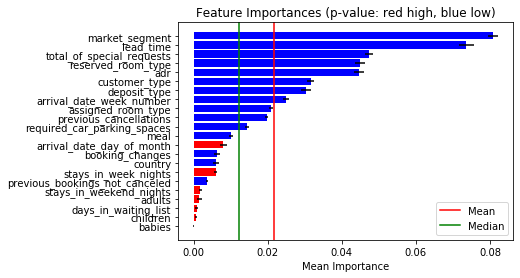

In [71]:
# Not important feats based on p-value: arrival_date_day_of_month, stays_in_week_nights, 
# stays_in_weekend_nights, adults, days_in_waiting_list, children and babies

fig, ax = plt.subplots()

# Example data
cols = manual_imp.index
y_pos = np.arange(len(cols))
imp = manual_imp['mean']
std = manual_imp['std']

colors = ['b','r']
for (i,col) in zip(y_pos,cols):
    if col == "arrival_date_day_of_month" or col == "stays_in_week_nights" or col == "stays_in_weekend_nights" or col == "adults" or col == "days_in_waiting_list" or col == "children" or col == "babies":
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[1], align='center')
    else:
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[0], align='center')
    
plt.axvline(x=manual_imp_mean, color='r', label = r"Mean")
plt.axvline(x=manual_imp_median, color='g', label = r"Median")
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Importance')
ax.set_title('Feature Importances (p-value: red high, blue low)')
plt.legend()

plt.show()

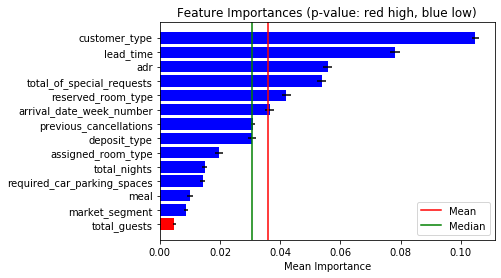

In [72]:
# Not important feats based on p-value: total_guests

fig, ax = plt.subplots()

# Example data
cols = final_manual_imp.index
y_pos = np.arange(len(cols))
imp = final_manual_imp['mean']
std = final_manual_imp['std']

colors = ['b','r']
for (i,col) in zip(y_pos,cols):
    if col == "total_guests":
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[1], align='center')
    else:
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[0], align='center')
        
plt.axvline(x=final_manual_imp_mean, color='r', label = r"Mean")
plt.axvline(x=final_manual_imp_median, color='g', label = r"Median")
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Importance')
ax.set_title('Feature Importances (p-value: red high, blue low)')
plt.legend()

plt.show()

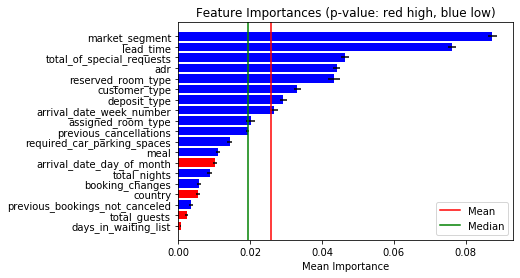

In [73]:
# Not important feats based on p-value: arrival_date_day_of_month, country, total_guests, days_in_waiting_list

fig, ax = plt.subplots()

# Example data
cols = final_final_manual_imp.index
y_pos = np.arange(len(cols))
imp = final_final_manual_imp['mean']
std = final_final_manual_imp['std']

colors = ['b','r']
for (i,col) in zip(y_pos,cols):
    if col == "arrival_date_day_of_month" or col == "country" or col == "days_in_waiting_list" or col == "total_guests":
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[1], align='center')
    else:
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[0], align='center')
        
plt.axvline(x=final_final_manual_imp_mean, color='r', label = r"Mean")
plt.axvline(x=final_final_manual_imp_median, color='g', label = r"Median")
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Importance')
ax.set_title('Feature Importances (p-value: red high, blue low)')
plt.legend()

plt.show()